# Gene-Peak Attention Score Analysis for Human Data

This notebook analyzes cross-modality attention scores between genes and chromatin accessibility peaks from MultiGATE model outputs. The pipeline includes data preprocessing, threshold determination via Gaussian Mixture Models, genomic distance calculations, and results visualization.

## Analysis Overview
The MultiGATE model learns cross-modality attention scores between RNA-seq gene and ATAC-seq peak. This analysis examines:
- **Attention scores**: Gene-peak interaction strengths
- **Threshold determination**: Optimal cutoff for significant interactions
- **Distance relationships**: Genomic distances between gene-peak pairs
- **Regulatory insights**: Potential regulatory relationships

## Table of Contents
1. [Data Loading and Setup](#data-loading)
2. [Attention Score Processing](#attention-processing) 
3. [Gene Annotation and Distance Calculation](#gene-annotation)
4. [Threshold Analysis using Gaussian Mixture Model](#threshold-analysis)
5. [Distance Analysis and Visualization](#distance-analysis)
6. [Results and Export](#results-export)


## 1. Data Loading and Setup {#data-loading}

Load data from MultiGATE model analysis:
- **Attention matrix**: Cross-modality attention scores between genes and peaks
- **AnnData objects**: Spatial RNA-seq and ATAC-seq data.

### Import Libraries

In [1]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Import required libraries
import scanpy as sc
import matplotlib.pyplot as plt
import os
import pandas as pd


### Load Attention Matrix
Load sparse attention matrix with cross-modal attention weights from trained MultiGATE model.


Run the [`Analyze Spatial ATAC–RNA-seq on Human Brain Hippocampal Formation Using MultiGATE` tutorial](https://multigate.readthedocs.io/en/latest/notebooks/human.html) to save the `peak_gene_attention.npz` file.

In [36]:
# Load sparse attention matrix from MultiGATE model output
import scipy.sparse as sp
gene_peak_attention = sp.load_npz(f'/lustre/project/Stat/s1155202250/fastfolder/code/st/MultiGATE/AttentionscoreHuman/peak_gene_attention.npz')
gene_peak_attention


<COOrdinate sparse matrix of dtype 'float32'
	with 63964 stored elements and shape (31270, 31270)>

### Load AnnData Objects
Load processed RNA-seq (adata1) and ATAC-seq (adata2) data with feature annotations and highly variable gene/peak selections.


In [37]:
# Load RNA (adata1) and ATAC (adata2) data objects
adata1 = sc.read_h5ad(f'/lustre/project/Stat/s1155202250/fastfolder/code/st/MultiGATE/tutorial/notebooks/output0313/human/adata1.h5ad')
adata2 = sc.read_h5ad(f'/lustre/project/Stat/s1155202250/fastfolder/code/st/MultiGATE/tutorial/notebooks/output0313/human/adata2.h5ad')

In [38]:
# Display RNA data structure
adata1

AnnData object with n_obs × n_vars = 2500 × 3000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'wnn'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'gene_peak_Net', 'hvg', 'log1p', 'wnn_colors'
    obsm: 'MultiGATE', 'MultiGATE_clip_all', 'X_umap', 'spatial'

In [39]:
# Display ATAC data structure
adata2

AnnData object with n_obs × n_vars = 2500 × 28270
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'wnn'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'chrom', 'chromStart', 'chromEnd'
    uns: 'Spatial_Net', 'gene_peak_Net', 'hvg', 'log1p'
    obsm: 'MultiGATE', 'MultiGATE_clip_all', 'X_umap', 'spatial'

In [40]:
# Display attention matrix structure  
gene_peak_attention

<COOrdinate sparse matrix of dtype 'float32'
	with 63964 stored elements and shape (31270, 31270)>

## 2. Attention Score Processing {#attention-processing}

Process raw attention matrix:
- Remove self-attention (diagonal elements)
- Filter for highly variable features
- Convert to structured DataFrame
- Clean zero-only rows/columns

### Process Attention Matrix


In [41]:
# Remove diagonal elements (self-attention)
gene_peak_attention = gene_peak_attention - sp.diags(gene_peak_attention.diagonal())

# Filter for highly variable features to reduce dimensionality
adata_Vars1 = adata1[:, adata1.var['highly_variable']]  # RNA-seq genes
adata_Vars2 = adata2[:, adata2.var['highly_variable']]  # ATAC-seq peaks

# Convert sparse matrix to DataFrame with feature names
df = pd.DataFrame(gene_peak_attention.toarray(), 
                  index=adata_Vars1.var.index.tolist() + adata_Vars2.var.index.tolist(),
                  columns=adata_Vars1.var.index.tolist() + adata_Vars2.var.index.tolist())

In [42]:
# Check row sums for data quality assessment
row_sum = df.sum(axis=1)
row_sum


LOC100288069              0.000000
UBE2J2                    0.707484
ACAP3                     0.698986
INTS11                    0.000000
CCNL2                     0.691254
                            ...   
GL000218.1-53309-54212    0.000000
GL000218.1-62719-63633    0.000000
GL000218.1-97012-97847    0.000000
KI270711.1-8063-8911      0.000000
KI270713.1-21531-22440    0.000000
Length: 31270, dtype: float32

In [43]:

# Check column sums for data quality assessment
col_sum = df.sum(axis=0)
col_sum

LOC100288069              0.000000
UBE2J2                    1.610752
ACAP3                     1.804340
INTS11                    0.000000
CCNL2                     1.547536
                            ...   
GL000218.1-53309-54212    0.000000
GL000218.1-62719-63633    0.000000
GL000218.1-97012-97847    0.000000
KI270711.1-8063-8911      0.000000
KI270713.1-21531-22440    0.000000
Length: 31270, dtype: float32

### Filter and Clean Data
Remove zero-only rows/columns to focus on features with actual attention relationships.


In [ ]:
# Remove rows and columns with all zeros
df = df.loc[df.any(axis=1), df.any(axis=0)]

In [ ]:
# Additional filtering to ensure no zero-only rows/columns remain
df = df.loc[(df != 0).any(axis=1), (df != 0).any(axis=0)]

In [ ]:
# Display filtered attention matrix
df

,UBE2J2,ACAP3,CCNL2,VWA1,CDK11B,CDK11A,PRKCZ,FAAP20,RER1,TPRG1L,...,chrX-154534510-154535346,chrX-154546873-154547786,chrX-154762366-154763240,chrX-154805029-154805872,chrX-155070969-155071885,chrX-155216080-155216882,chrX-155263921-155264798,chrY-2935610-2936340,chrY-12904507-12905211,chrY-12905335-12905890
UBE2J2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACAP3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCNL2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VWA1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CDK11B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX-155216080-155216882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrX-155263921-155264798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrY-2935610-2936340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrY-12904507-12905211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Filter for cross-modal gene-peak interactions only
# Keep rows corresponding to genes (from RNA-seq data)
df = df[df.index.isin(adata1.var.index.tolist())]
# Keep columns corresponding to peaks (from ATAC-seq data)  
df = df[df.columns.intersection(adata2.var_names)]

In [ ]:
# Display final gene-peak attention matrix
df

,chr1-1157190-1157915,chr1-1158055-1158931,chr1-1173492-1174276,chr1-1182600-1183455,chr1-1185008-1185889,chr1-1231565-1232471,chr1-1273551-1274462,chr1-1280868-1281738,chr1-1307809-1308677,chr1-1324350-1325288,...,chrX-154534510-154535346,chrX-154546873-154547786,chrX-154762366-154763240,chrX-154805029-154805872,chrX-155070969-155071885,chrX-155216080-155216882,chrX-155263921-155264798,chrY-2935610-2936340,chrY-12904507-12905211,chrY-12905335-12905890
UBE2J2,0.017877,0.016684,0.017549,0.020722,0.019547,0.032758,0.292515,0.128588,0.043216,0.028415,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
ACAP3,0.000000,0.000000,0.017934,0.023700,0.020028,0.026982,0.037905,0.068760,0.241069,0.077260,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
CCNL2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013758,0.014506,0.017519,0.020215,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
VWA1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035416,0.021036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
CDK11B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FAM50A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.038108,0.084062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
DKC1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.475737,0.048526,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
VBP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.035342,0.133867,0.055419,0.000000,0.000000,0.00000
RPS4Y1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072037,0.000000,0.00000


## 3. Gene Annotation and Distance Calculation {#gene-annotation}

Annotate genes with genomic coordinates and create gene-peak pairs:
- Load gene annotations from GTF files
- Parse genomic coordinates for genes and peaks
- Create structured gene-peak interaction pairs
- Merge attention scores with genomic annotations

### Import Additional Libraries


In [ ]:
# Import libraries for data processing and pattern matching
import pandas as pd
import re     
import numpy as np

### Extract Gene Annotations and Create Gene-Peak Pairs
Process human genome GTF file to extract gene coordinates and create gene-peak interaction pairs with attention scores.


In [ ]:
# Extract gene names from attention matrix for annotation lookup
var_by = df.index

# Load human genome annotation file (GENCODE v25)
# This contains comprehensive gene annotations with genomic coordinates
gtf = '/lustre/project/Stat/s1155077016/Spatial_multi-omics_data/Human/gencode.v25.chr_patch_hapl_scaff.annotation.gtf.gz'
gtf_by = "gene_name"  # Use gene_name field for matching
COLUMNS = pd.Index(["seqname", "source", "feature", "start", "end", "score", "strand",
                    "frame", "attribute"])

# Read GTF file and filter for gene entries only
loaded = pd.read_csv(gtf, sep="\t", header=None, comment="#")
loaded.columns = COLUMNS[:loaded.shape[1]]
loaded = loaded.query("feature == 'gene'")  # Keep only gene annotations

# Parse GTF attributes (9th column) using regex to extract key-value pairs
# GTF format: attribute_name "attribute_value"; 
pattern = re.compile(r'([^\s]+) "([^"]+)";')
splitted = pd.DataFrame.from_records(np.vectorize(lambda x: {
    key: val for key, val in pattern.findall(x)
})(loaded["attribute"]), index=loaded.index)
loaded = loaded.assign(**splitted)
loaded = loaded.sort_values("seqname").drop_duplicates(subset=[gtf_by], keep="last")

# Create BED format DataFrame  
bed_df = pd.DataFrame(loaded, copy=True).loc[:, ("seqname", "start", "end", "score", "strand")]
bed_df.insert(3, "name", np.repeat(".", len(bed_df)) if gtf_by is None else loaded[gtf_by])
bed_df["start"] -= 1  # Convert to zero-based coordinates
bed_df.columns = ("chrom", "chromStart", "chromEnd", "name", "score", "strand")

# Ensure proper data types
for item in bed_df.columns:
    if item in bed_df:
        if item in ("chromStart", "chromEnd"):
            bed_df[item] = bed_df[item].astype(int)
        else:
            bed_df[item] = bed_df[item].astype(str)
    elif item not in ("chrom", "chromStart", "chromEnd"):
        bed_df[item] = "."

# Create gene annotation DataFrame with genomic coordinates
gene_df = pd.concat([
    pd.DataFrame(bed_df),
    pd.DataFrame(loaded).drop(columns=COLUMNS)
], axis=1).set_index(gtf_by).reindex(var_by).set_index(df.index)
gene_df = gene_df[['chrom', 'chromStart', 'chromEnd']]

# Extract non-zero attention scores and create gene-peak pairs
non_zero_df = df[df > 0.0]
stacked = non_zero_df.stack()
result = stacked.reset_index()
result.columns = ['gene', 'peak', 'score']
result = result.sort_values(by=['gene', 'score'], ascending=[True, False])
result = result.reset_index(drop=True)

# Merge gene annotations with attention scores
merged_df = result.merge(gene_df, left_on='gene', right_index=True, how='left')

# Reorganize columns for better readability
chrom_col = merged_df.pop('chrom')
merged_df.insert(1, 'chrom', chrom_col)
chrom_col = merged_df.pop('chromStart')
merged_df.insert(2, 'chromStart', chrom_col)
chrom_col = merged_df.pop('chromEnd')
merged_df.insert(3, 'chromEnd', chrom_col)

# Parse peak coordinates from peak names (format: chr-start-end)
merged_df[['peak_chrom', 'peak_start', 'peak_end']] = merged_df['peak'].str.split('-', expand=True)

# Reorganize peak coordinate columns
chrom_col = merged_df.pop('peak_chrom')
merged_df.insert(5, 'peak_chrom', chrom_col)
chrom_col = merged_df.pop('peak_start')
merged_df.insert(6, 'peak_start', chrom_col)
chrom_col = merged_df.pop('peak_end')
merged_df.insert(7, 'peak_end', chrom_col)


In [ ]:
# Display merged dataframe with gene and peak coordinates
merged_df

,gene,chrom,chromStart,chromEnd,peak,peak_chrom,peak_start,peak_end,score
0,A2M,chr12,9067663,9116229,chr12-9115492-9116400,chr12,9115492,9116400,0.324062
1,A2M,chr12,9067663,9116229,chr12-9117970-9118894,chr12,9117970,9118894,0.324062
2,A2M,chr12,9067663,9116229,chr12-9064332-9065050,chr12,9064332,9065050,0.027813
3,ABCA1,chr9,104781001,104928237,chr9-104926201-104927103,chr9,104926201,104927103,0.320480
4,ABCA1,chr9,104781001,104928237,chr9-104968056-104968871,chr9,104968056,104968871,0.055043
...,...,...,...,...,...,...,...,...,...
16342,ZSWIM7,chr17,15976559,15999717,chr17-15965296-15966096,chr17,15965296,15966096,0.060453
16343,ZSWIM7,chr17,15976559,15999717,chr17-15944636-15945512,chr17,15944636,15945512,0.054623
16344,ZZEF1,chr17,4004444,4143020,chr17-4142763-4143403,chr17,4142763,4143403,0.326784
16345,ZZEF1,chr17,4004444,4143020,chr17-4143520-4144206,chr17,4143520,4144206,0.326784


In [ ]:
# Normalize attention scores to 0-1 range for consistent analysis
# This ensures all scores are on the same scale for threshold determination
merged_df['score'] = (merged_df['score'] - merged_df['score'].min()) / (merged_df['score'].max() - merged_df['score'].min())
merged_df

,gene,chrom,chromStart,chromEnd,peak,peak_chrom,peak_start,peak_end,score
0,A2M,chr12,9067663,9116229,chr12-9115492-9116400,chr12,9115492,9116400,0.642624
1,A2M,chr12,9067663,9116229,chr12-9117970-9118894,chr12,9117970,9118894,0.642624
2,A2M,chr12,9067663,9116229,chr12-9064332-9065050,chr12,9064332,9065050,0.040864
3,ABCA1,chr9,104781001,104928237,chr9-104926201-104927103,chr9,104926201,104927103,0.635348
4,ABCA1,chr9,104781001,104928237,chr9-104968056-104968871,chr9,104968056,104968871,0.096176
...,...,...,...,...,...,...,...,...,...
16342,ZSWIM7,chr17,15976559,15999717,chr17-15965296-15966096,chr17,15965296,15966096,0.107165
16343,ZSWIM7,chr17,15976559,15999717,chr17-15944636-15945512,chr17,15944636,15945512,0.095322
16344,ZZEF1,chr17,4004444,4143020,chr17-4142763-4143403,chr17,4142763,4143403,0.648152
16345,ZZEF1,chr17,4004444,4143020,chr17-4143520-4144206,chr17,4143520,4144206,0.648152


## 4. Threshold Analysis using Gaussian Mixture Model {#threshold-analysis}

Determine optimal threshold for significant attention scores using Gaussian Mixture Models (GMM):
- Fit 2-component GMM to attention score distribution
- Identify bimodal distribution components
- Calculate intersection point as optimal threshold
- Classify gene-peak interactions as high/low attention

### Calculate Optimal Threshold

In [ ]:
# Import required libraries for GMM analysis
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
from sklearn.metrics import silhouette_score
import diptest  # Import diptest for bimodality testing

# Configure matplotlib to use Arial font
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42  # To ensure text is editable in PDF
plt.rcParams['ps.fonttype'] = 42  # To ensure text is editable in PS/EPS

# Increase font sizes for academic publication
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=MEDIUM_SIZE)          # Default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # Axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # x tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # y tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # Legend
plt.rc('figure', titlesize=BIGGER_SIZE)   # Figure title

print("Libraries imported successfully for GMM analysis.")


Libraries imported successfully for GMM analysis.


In [ ]:
# Create results file for GMM analysis
results_file = open('Human_GMM_analysis_results.txt', 'w')
print("Human GMM Analysis Results for Attention Scores")
print("=" * 47)

# Prepare attention score data for GMM analysis
df_scores = merged_df['score']
data = df_scores.values.reshape(-1, 1)

print(f"Analyzing {len(data)} attention score values...")
print(f"Score range: {data.min():.4f} to {data.max():.4f}")

Human GMM Analysis Results for Attention Scores
Analyzing 16347 attention score values...
Score range: 0.0000 to 1.0000


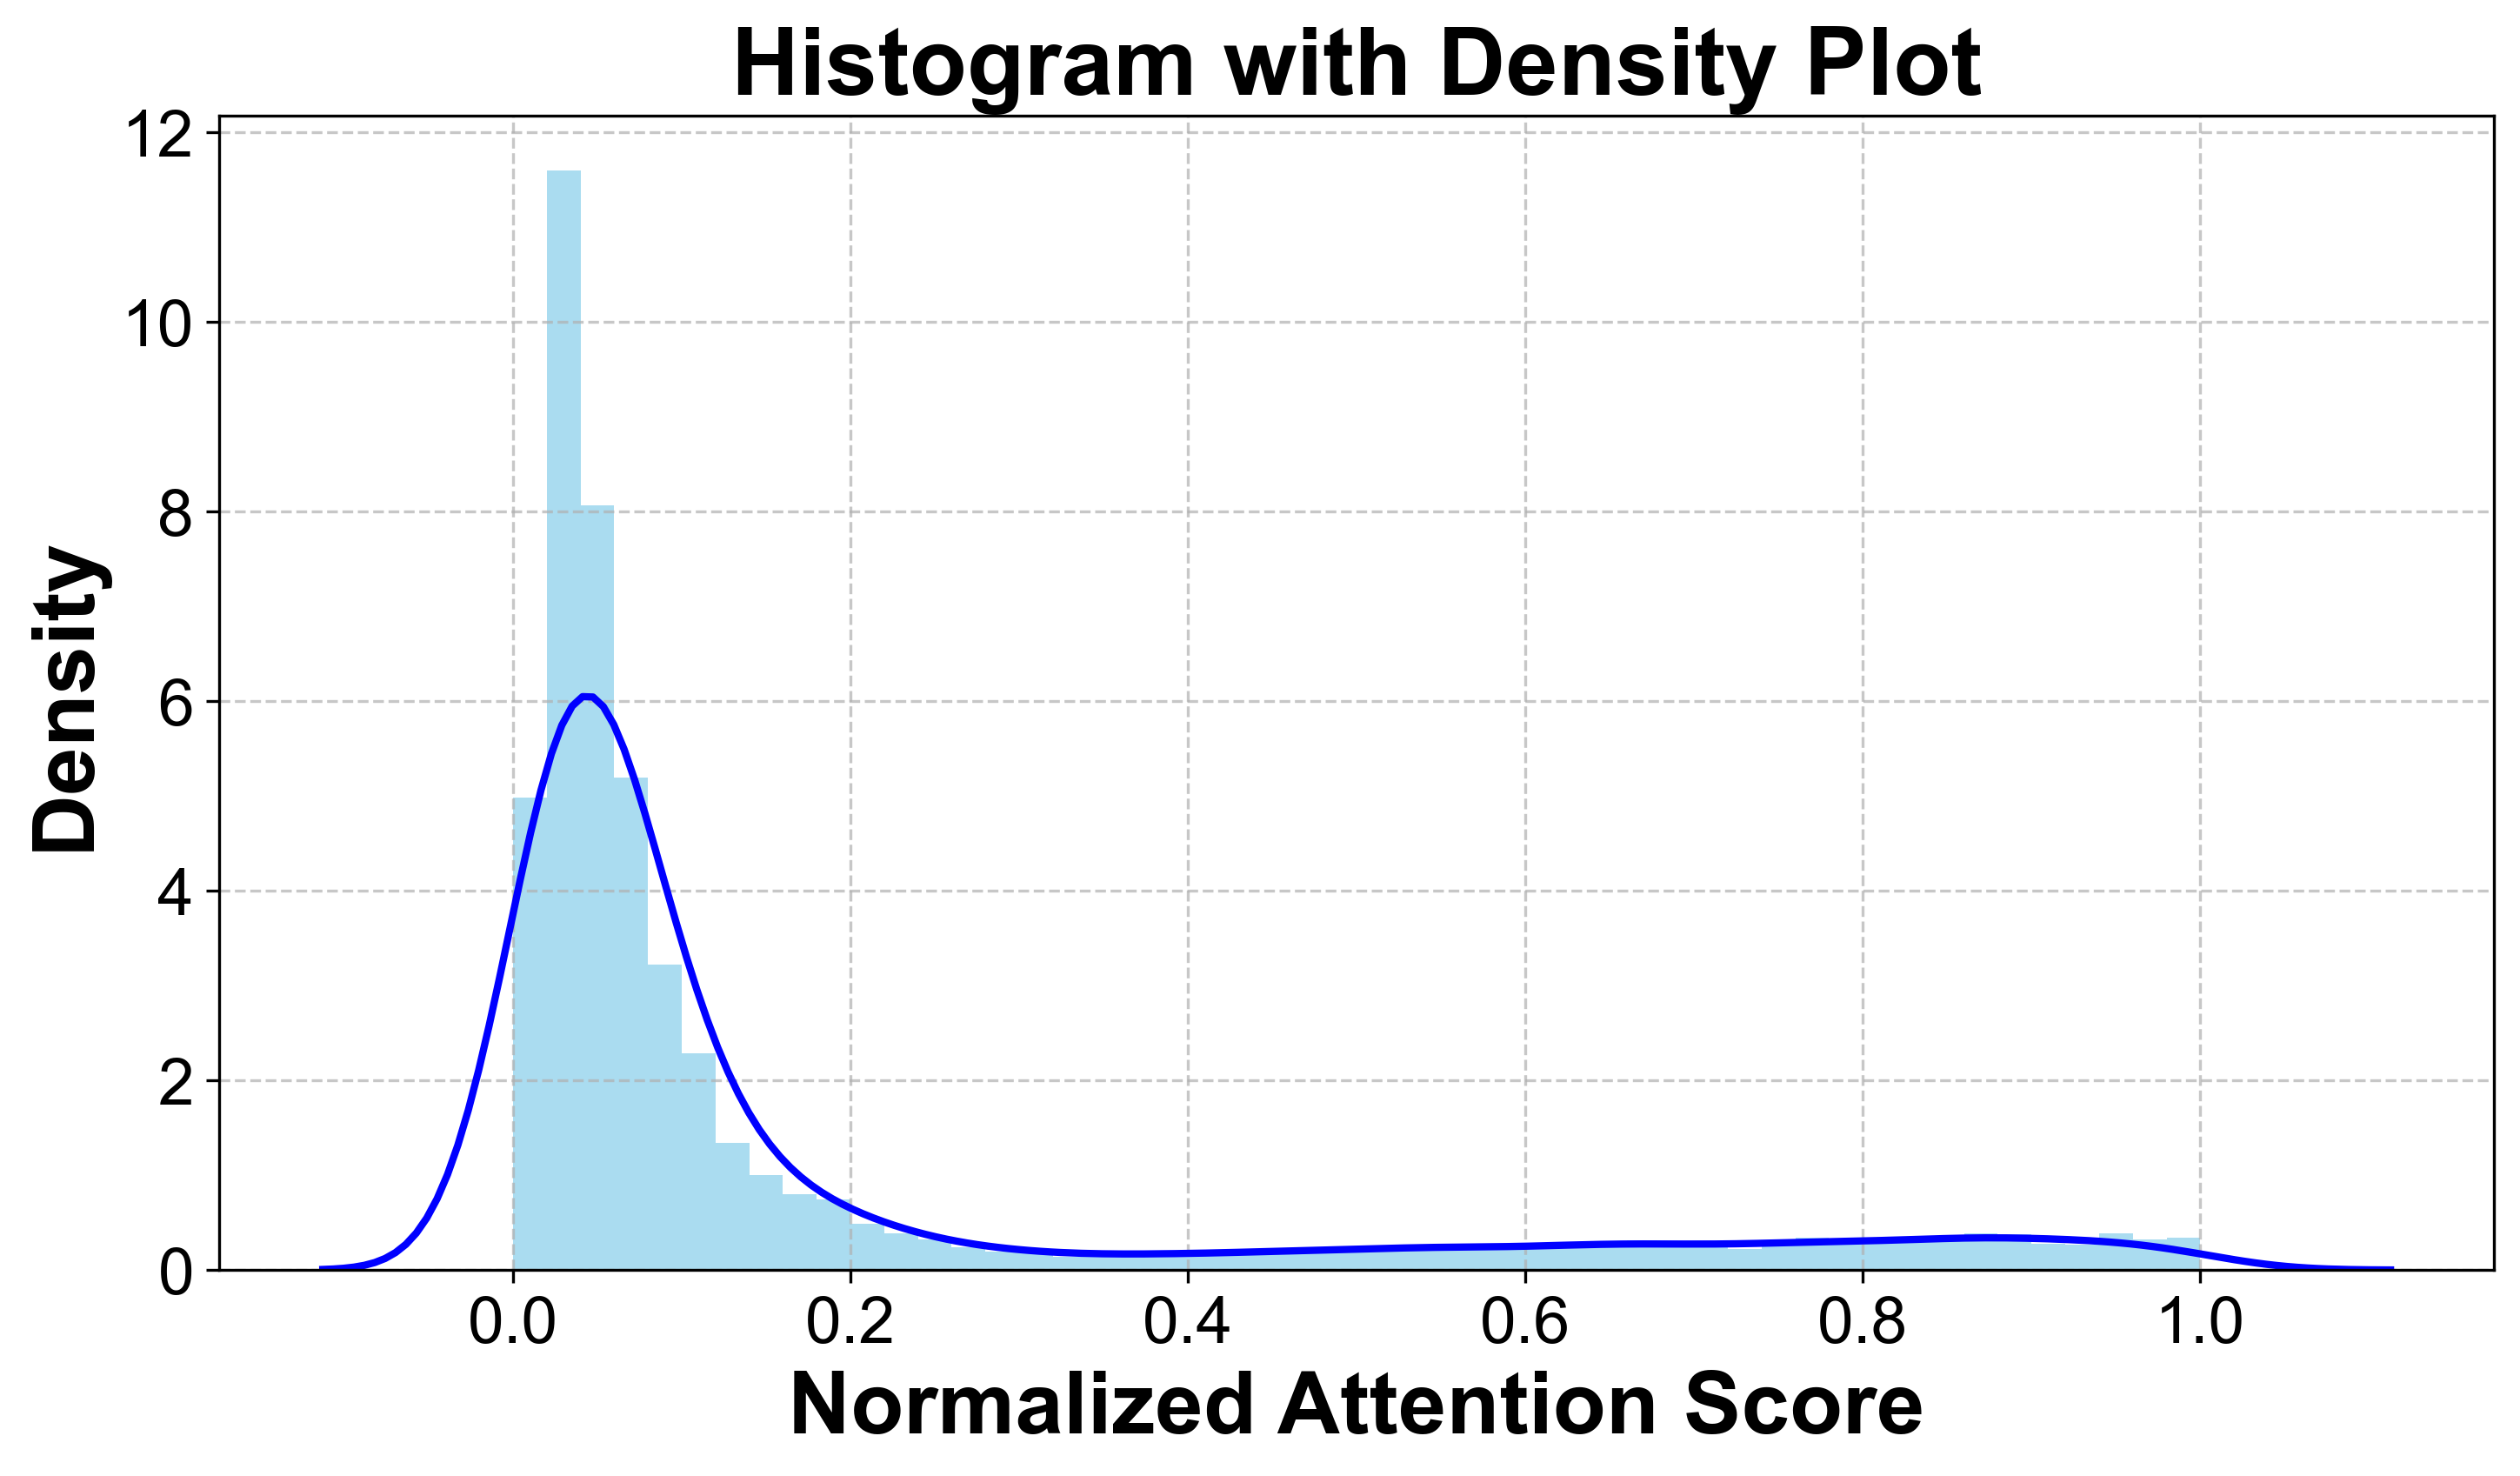

Initial histogram and density plot generated.


In [ ]:
# 1. Visual verification of bimodality with histogram
plt.figure(figsize=(10, 6), dpi=300)
n, bins, patches = plt.hist(
    data, bins=50, density=True, alpha=0.7, color='skyblue')
sns.kdeplot(data.flatten(), color='blue', linewidth=2)
plt.xlabel('Normalized Attention Score', fontsize=BIGGER_SIZE, fontweight='bold')
plt.ylabel('Density', fontsize=BIGGER_SIZE, fontweight='bold')
plt.title(
    'Histogram with Density Plot', 
    fontsize=BIGGER_SIZE+2, 
    fontweight='bold'
)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Initial histogram and density plot generated.")


In [ ]:
# 4. Main GMM analysis with 2 components to find threshold
# Define and fit the Gaussian Mixture Model with 2 components
gmm = GaussianMixture(
    n_components=2, 
    init_params='kmeans', 
    covariance_type='full', 
    n_init=10, 
    random_state=42
)
gmm.fit(data)

# Print the parameters of the model
weights = gmm.weights_
means = gmm.means_
covariances = gmm.covariances_
print(f"Component weights: {weights}")
print(f"Component means: {means.flatten()}")
print(f"Component variances: {[cov[0][0] for cov in covariances]}")

# Calculate Ashman's D for measuring component separation
d = np.abs(means[0]-means[1]) / np.sqrt(
    0.5*(covariances[0][0, 0]+covariances[1][0, 0]))
d = d.item()  # Extract scalar value from numpy array
print(f"Ashman D = {d:.2f}")   # D > 2 typically indicates good separation

# Write GMM parameters to results file
print("3. 2-Component GMM Parameters\n")
print(f"   Component weights: {weights}\n")
print(f"   Component means: {means.flatten()}\n")
print(
    f"   Component variances: {[cov[0][0] for cov in covariances]}\n")

Component weights: [0.72295037 0.27704963]
Component means: [0.05164618 0.51825354]
Component variances: [0.0010219686651115037, 0.08705019830010119]
Ashman D = 2.22
3. 2-Component GMM Parameters

   Component weights: [0.72295037 0.27704963]

   Component means: [0.05164618 0.51825354]

   Component variances: [0.0010219686651115037, 0.08705019830010119]



Identified threshold at score = 0.1416
4. Identified threshold = 0.1416




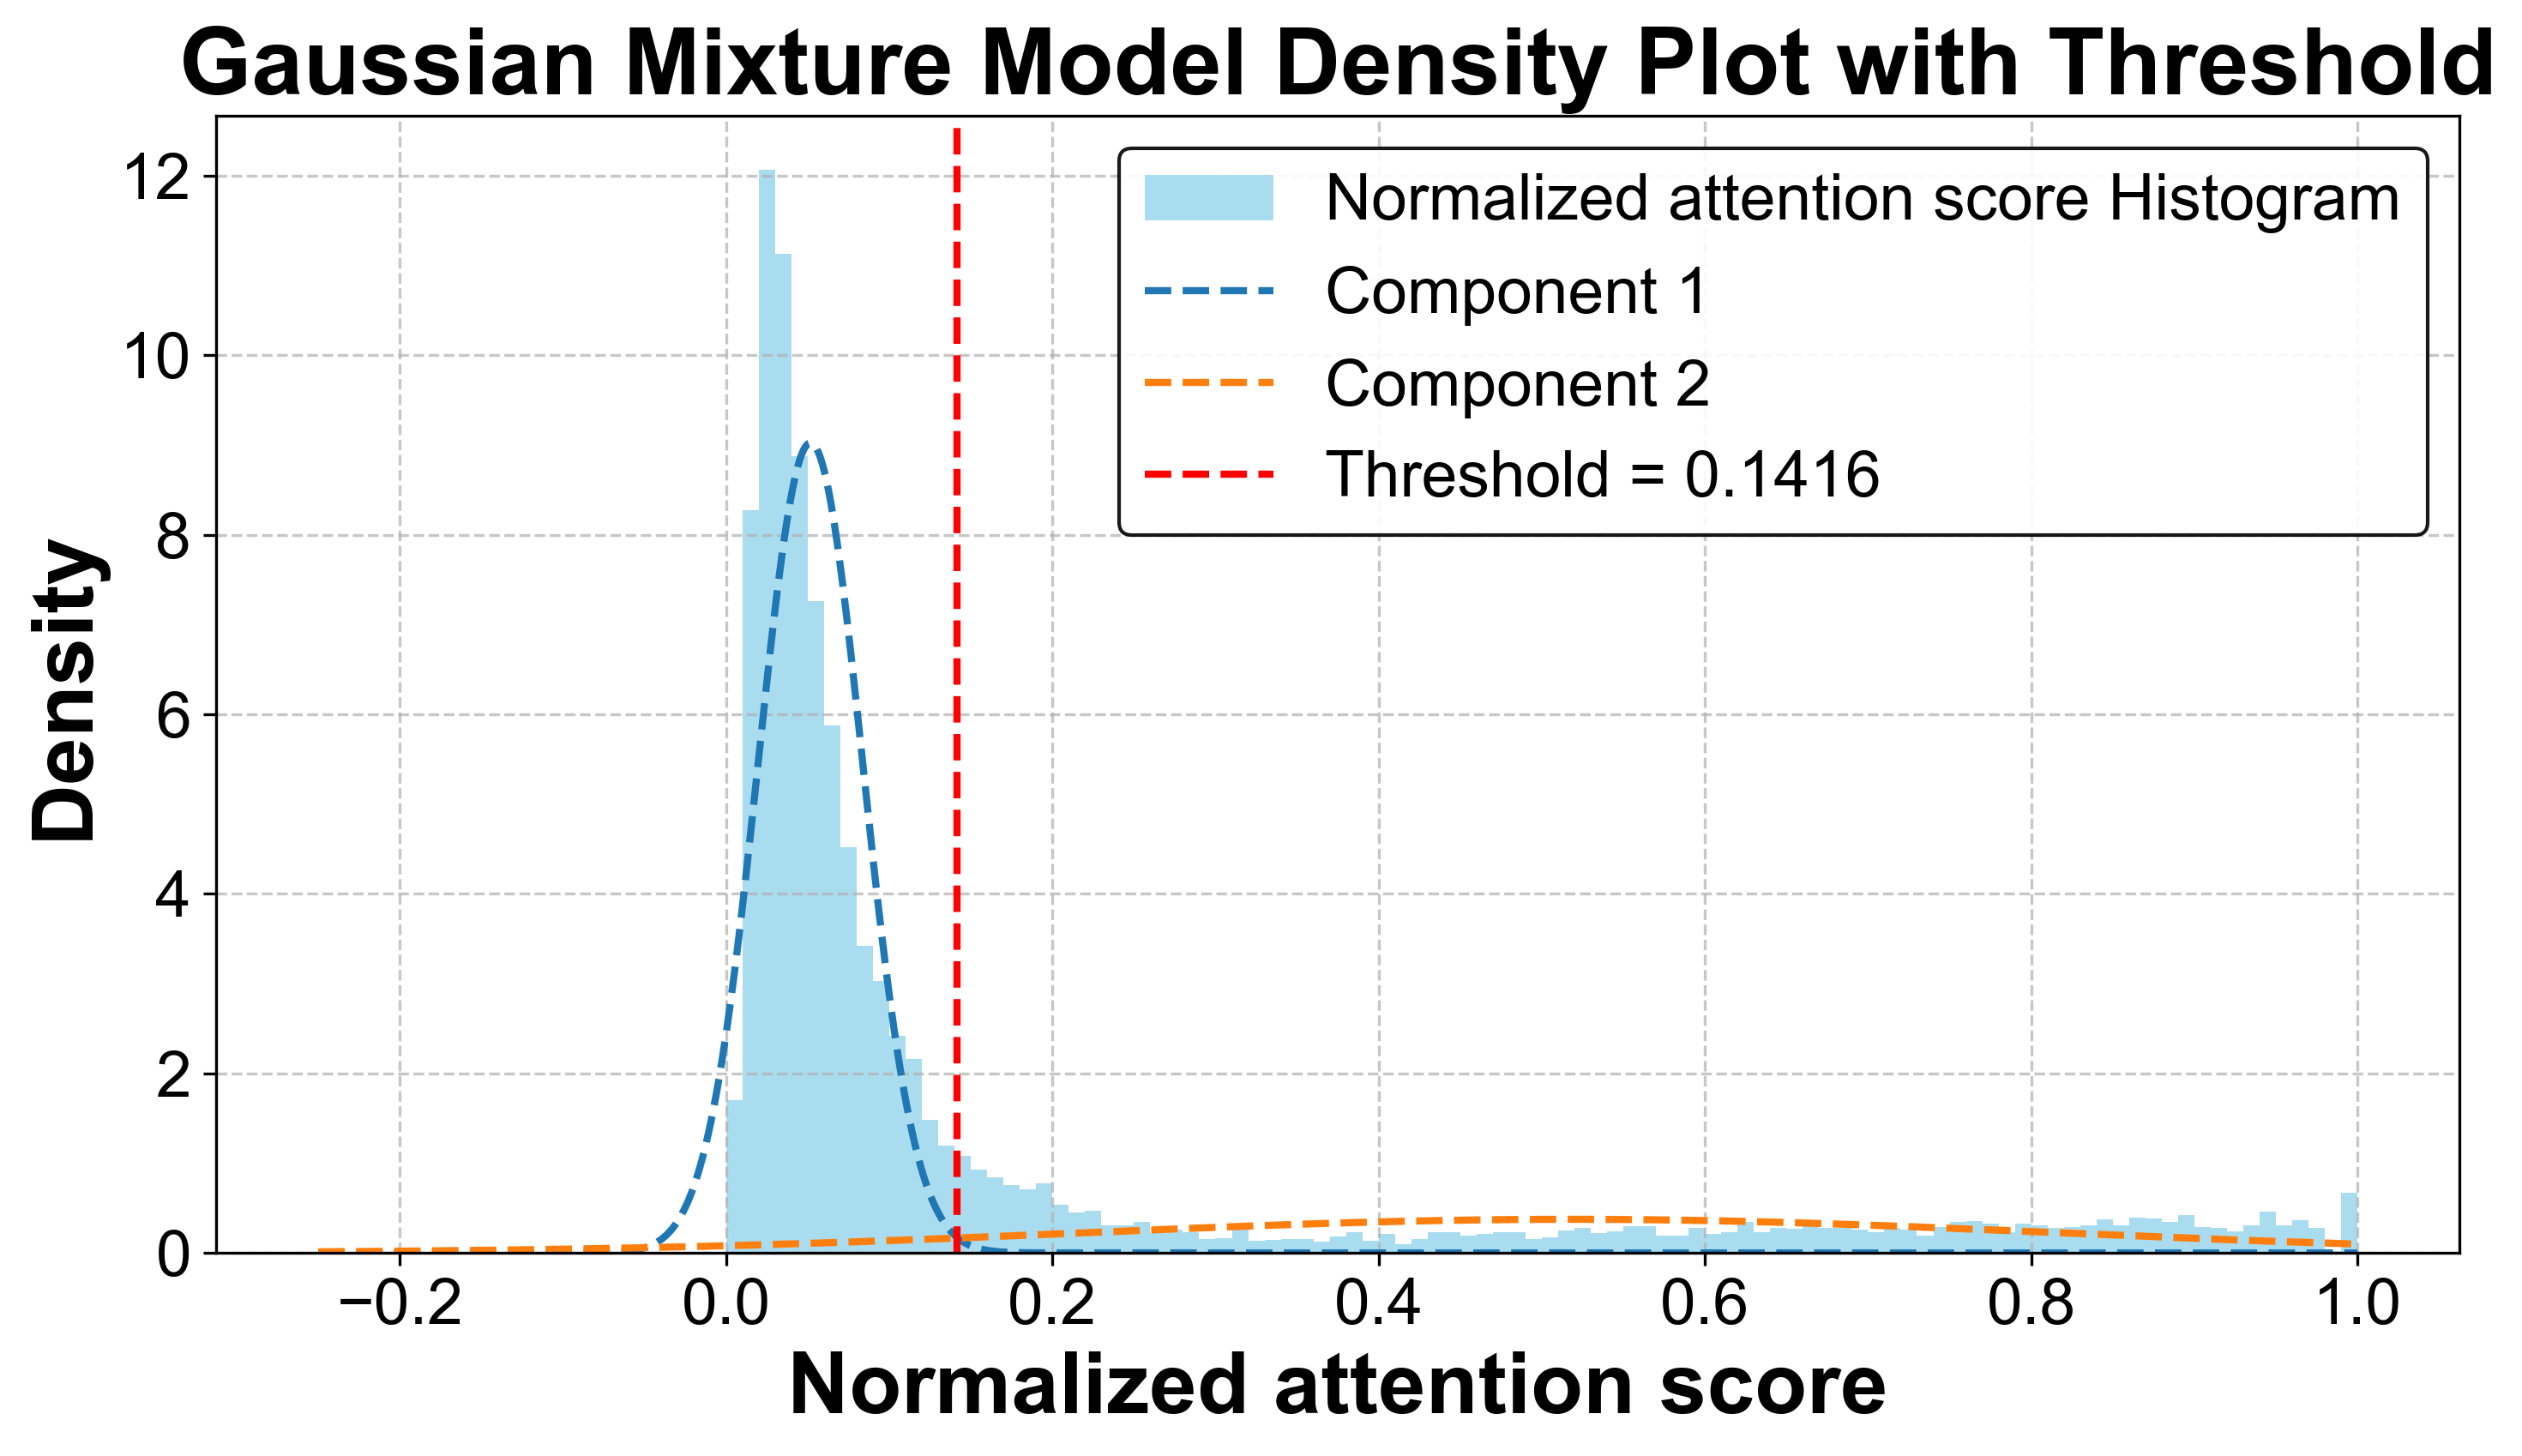

Final threshold value: 0.1416


In [ ]:
# Create high-quality figure for GMM plot and threshold identification
plt.figure(figsize=(10, 6), dpi=300)

# Generate the histogram plot instead of density plot
plt.hist(data.flatten(), bins=100, density=True, alpha=0.7, color='skyblue', 
         label='Normalized attention score Histogram')

# Plot the density of each Gaussian component
# Use data range instead of fixed 0-1 range
data_min, data_max = data.min(), data.max()
x = np.linspace(-0.25, 1, 1000).reshape(-1, 1)

logprob = gmm.score_samples(x)
pdf = np.exp(logprob)
responsibilities = gmm.predict_proba(x)
pdf_individual = responsibilities * pdf[:, np.newaxis]

for i in range(gmm.n_components):
    plt.plot(
        x, 
        pdf_individual[:, i], 
        label=f'Component {i+1}', 
        linestyle='dashed', 
        linewidth=2
    )

# Find the intersection point (threshold) between the two Gaussian components
component_1_pdf = pdf_individual[:, 0]
component_2_pdf = pdf_individual[:, 1]
intersection_idx = np.argwhere(
    np.diff(np.sign(component_1_pdf - component_2_pdf))
).flatten()

if len(intersection_idx) == 1:
    threshold = x[intersection_idx[0]]
    plt.axvline(
        threshold, 
        color='red', 
        linestyle='--', 
        linewidth=2, 
        label=f'Threshold = {threshold[0]:.4f}'
    )
    print(f"Identified threshold at score = {threshold[0]:.4f}")
    print(f"4. Identified threshold = {threshold[0]:.4f}\n\n")
elif len(intersection_idx) == 2:
    threshold = x[intersection_idx[1]]
    plt.axvline(
        threshold, 
        color='red', 
        linestyle='--', 
        linewidth=2, 
        label=f'Threshold = {threshold[0]:.4f}'
    )
    print(f"Identified threshold at score = {threshold[0]:.4f}")
    print(f"4. Identified threshold = {threshold[0]:.4f}\n\n")
else:
    print("No intersection found between components")
    threshold = np.array([[0.5]])  # Default fallback
    print(
        "4. No intersection found between components. "
        "Using default threshold = 0.5\n\n")

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add labels and title with larger font sizes
plt.xlabel('Normalized attention score', fontsize=BIGGER_SIZE, fontweight='bold')
plt.ylabel('Density', fontsize=BIGGER_SIZE, fontweight='bold')
plt.title(
    'Gaussian Mixture Model Density Plot with Threshold',
    fontsize=BIGGER_SIZE+2, 
    fontweight='bold'
)

# Improve legend appearance
plt.legend(loc='best', frameon=True, framealpha=0.9, edgecolor='black')

# Tight layout for better spacing
plt.tight_layout()



# Also save as a separate PDF for the main figure
plt.savefig(
    'Human_gaussian_mixture_density_plot.pdf', 
    format='pdf', 
    bbox_inches='tight'
)

# Show the plot
plt.show()

# Store threshold value for later use
attention_threshold = threshold[0] if isinstance(threshold, np.ndarray) else threshold
print(f"Final threshold value: {attention_threshold:.4f}")


In [ ]:
# 8. Apply threshold to merged_df and create binary classification
print(f"Applying threshold {attention_threshold:.4f} to classify gene-peak interactions...")

# Add threshold-based classification to merged_df
merged_df['high_attention'] = merged_df['score'] >= attention_threshold
merged_df['attention_class'] = merged_df['high_attention'].map({True: 'High', False: 'Low'})



Applying threshold 0.1416 to classify gene-peak interactions...


In [ ]:
merged_df

,gene,chrom,chromStart,chromEnd,peak,peak_chrom,peak_start,peak_end,score,high_attention,attention_class
0,A2M,chr12,9067663,9116229,chr12-9115492-9116400,chr12,9115492,9116400,0.642624,True,High
1,A2M,chr12,9067663,9116229,chr12-9117970-9118894,chr12,9117970,9118894,0.642624,True,High
2,A2M,chr12,9067663,9116229,chr12-9064332-9065050,chr12,9064332,9065050,0.040864,False,Low
3,ABCA1,chr9,104781001,104928237,chr9-104926201-104927103,chr9,104926201,104927103,0.635348,True,High
4,ABCA1,chr9,104781001,104928237,chr9-104968056-104968871,chr9,104968056,104968871,0.096176,False,Low
...,...,...,...,...,...,...,...,...,...,...,...
16342,ZSWIM7,chr17,15976559,15999717,chr17-15965296-15966096,chr17,15965296,15966096,0.107165,False,Low
16343,ZSWIM7,chr17,15976559,15999717,chr17-15944636-15945512,chr17,15944636,15945512,0.095322,False,Low
16344,ZZEF1,chr17,4004444,4143020,chr17-4142763-4143403,chr17,4142763,4143403,0.648152,True,High
16345,ZZEF1,chr17,4004444,4143020,chr17-4143520-4144206,chr17,4143520,4144206,0.648152,True,High


In [ ]:
# Apply threshold filter: set low attention scores to 0
# This creates a binary classification of significant vs. non-significant interactions
merged_df['score'] = merged_df['score'].apply(lambda x: 0 if x < attention_threshold else x)

# Export dataset with threshold-based filtering applied
merged_df.to_csv('merged_df_threshold.csv', index=False)
print(f"Threshold-filtered dataset exported to: merged_df_threshold.csv")

Threshold-filtered dataset exported to: merged_df_threshold.csv


## 5. Distance Analysis and Visualization {#distance-analysis}

Calculate genomic distances between genes and peaks using interval-based methods:
- Convert coordinate data types for calculation
- Implement interval distance functions
- Calculate distances between gene-peak pairs
- Generate distance distribution visualizations

### Prepare Data for Distance Calculation


In [ ]:
# Convert genomic coordinate columns to integer data type for numerical calculations
# Ensure all coordinate values are properly formatted for distance computation
merged_df['peak_start'] = merged_df['peak_start'].astype(int)
merged_df['chromStart'] = merged_df['chromStart'].astype(int)

### Define Genomic Interval Class and Distance Function
Implement interval-based distance calculation handling:
- Different chromosomes (infinite distance)
- Overlapping intervals (zero distance)
- Non-overlapping intervals (gap length)


In [ ]:
# Import required libraries for distance calculation
from dataclasses import dataclass
from typing import Union
import numpy as np
import pandas as pd

@dataclass
class Interval:
    """Class representing genomic intervals"""
    chrom: str
    start: int
    stop: int
    
    def __init__(self, chrom: str, start: int, stop: int):
        self.chrom = str(chrom)
        self.start = int(start)
        self.stop = int(stop)

def interval_dist(x: Interval, y: Interval) -> int:
    """
    Calculate distance between two genomic intervals
    
    Parameters:
    -----------
    x, y : Interval
        Two genomic intervals
    
    Returns:
    --------
    int : Distance value
        - Different chromosomes return infinity
        - Overlapping intervals return 0
        - Non-overlapping intervals return gap length (signed)
    """
    # Different chromosomes: return ±∞ (filtered out later)
    if x.chrom != y.chrom:
        return np.inf * (-1 if x.chrom < y.chrom else 1)
    
    # Overlapping intervals: distance = 0
    if x.start < y.stop and y.start < x.stop:
        return 0
    
    # x completely before y (x.stop <= y.start)
    # Calculate x.stop - y.start - 1, result is negative, absolute value is gap length
    if x.stop <= y.start:
        return x.stop - y.start - 1
    
    # y completely before x (y.stop <= x.start)  
    # Calculate x.start - y.stop + 1, positive value is gap length
    if y.stop <= x.start:
        return x.start - y.stop + 1


### Apply Distance Calculation to Current Data


In [ ]:
# Skip the original distance calculation - will use new interval-based distance instead
merged_df

,gene,chrom,chromStart,chromEnd,peak,peak_chrom,peak_start,peak_end,score,high_attention,attention_class
0,A2M,chr12,9067663,9116229,chr12-9115492-9116400,chr12,9115492,9116400,0.642624,True,High
1,A2M,chr12,9067663,9116229,chr12-9117970-9118894,chr12,9117970,9118894,0.642624,True,High
2,A2M,chr12,9067663,9116229,chr12-9064332-9065050,chr12,9064332,9065050,0.000000,False,Low
3,ABCA1,chr9,104781001,104928237,chr9-104926201-104927103,chr9,104926201,104927103,0.635348,True,High
4,ABCA1,chr9,104781001,104928237,chr9-104968056-104968871,chr9,104968056,104968871,0.000000,False,Low
...,...,...,...,...,...,...,...,...,...,...,...
16342,ZSWIM7,chr17,15976559,15999717,chr17-15965296-15966096,chr17,15965296,15966096,0.000000,False,Low
16343,ZSWIM7,chr17,15976559,15999717,chr17-15944636-15945512,chr17,15944636,15945512,0.000000,False,Low
16344,ZZEF1,chr17,4004444,4143020,chr17-4142763-4143403,chr17,4142763,4143403,0.648152,True,High
16345,ZZEF1,chr17,4004444,4143020,chr17-4143520-4144206,chr17,4143520,4144206,0.648152,True,High


In [ ]:
# Calculate genomic distances using interval-based method
def calculate_new_distance(merged_df):
    """
    Calculate genomic distances between genes and peaks
    
    Handles:
    - Overlapping intervals (distance = 0)
    - Different chromosomes (distance = NaN, filtered out)
    - Non-overlapping intervals (gap length in base pairs)
    
    Returns list of absolute distances in base pairs
    """
    new_distances = []
    
    for idx, row in merged_df.iterrows():
        # Create gene and peak intervals
        gene_interval = Interval(row['chrom'], row['chromStart'], row['chromEnd'])
        peak_interval = Interval(row['peak_chrom'], int(row['peak_start']), int(row['peak_end']))
        
        # Calculate distance
        dist = interval_dist(gene_interval, peak_interval)
        new_distances.append(abs(dist) if dist != np.inf else np.nan)
    
    return new_distances

# Apply distance calculation
print("Calculating genomic distances using interval-based method...")
merged_df['new_distance'] = calculate_new_distance(merged_df)

# Filter out inter-chromosomal interactions
merged_df_filtered = merged_df[~merged_df['new_distance'].isna()].copy()

print(f"Original gene-peak pairs: {len(merged_df)}")
print(f"Intra-chromosomal pairs: {len(merged_df_filtered)}")

# Convert to kilobases and clean up columns
merged_df_filtered['new_distance_kb'] = merged_df_filtered['new_distance'] / 1000
merged_df_filtered = merged_df_filtered.drop(columns=['new_distance'])
merged_df_filtered = merged_df_filtered.rename(columns={'new_distance_kb': 'distance'})

# Display summary
merged_df_filtered[['gene', 'peak', 'score', 'distance']].head(10)


Calculating genomic distances using interval-based method...


Original gene-peak pairs: 16347
Intra-chromosomal pairs: 16347


,gene,peak,score,distance
0,A2M,chr12-9115492-9116400,0.642624,0.000
1,A2M,chr12-9117970-9118894,0.642624,1.742
2,A2M,chr12-9064332-9065050,0.000000,2.614
3,ABCA1,chr9-104926201-104927103,0.635348,0.000
4,ABCA1,chr9-104968056-104968871,0.000000,39.820
5,ABCA1,chr9-104862979-104863870,0.000000,0.000
6,ABCA1,chr9-104868758-104869593,0.000000,0.000
7,ABCA1,chr9-104991254-104992032,0.000000,63.018
8,ABCA1,chr9-104993335-104994192,0.000000,65.099
9,ABCA1,chr9-105064157-105064988,0.000000,135.921


### Generate Distance Distribution Visualization
Create publication-quality visualizations of the gene-peak distance distribution and calculate summary statistics.


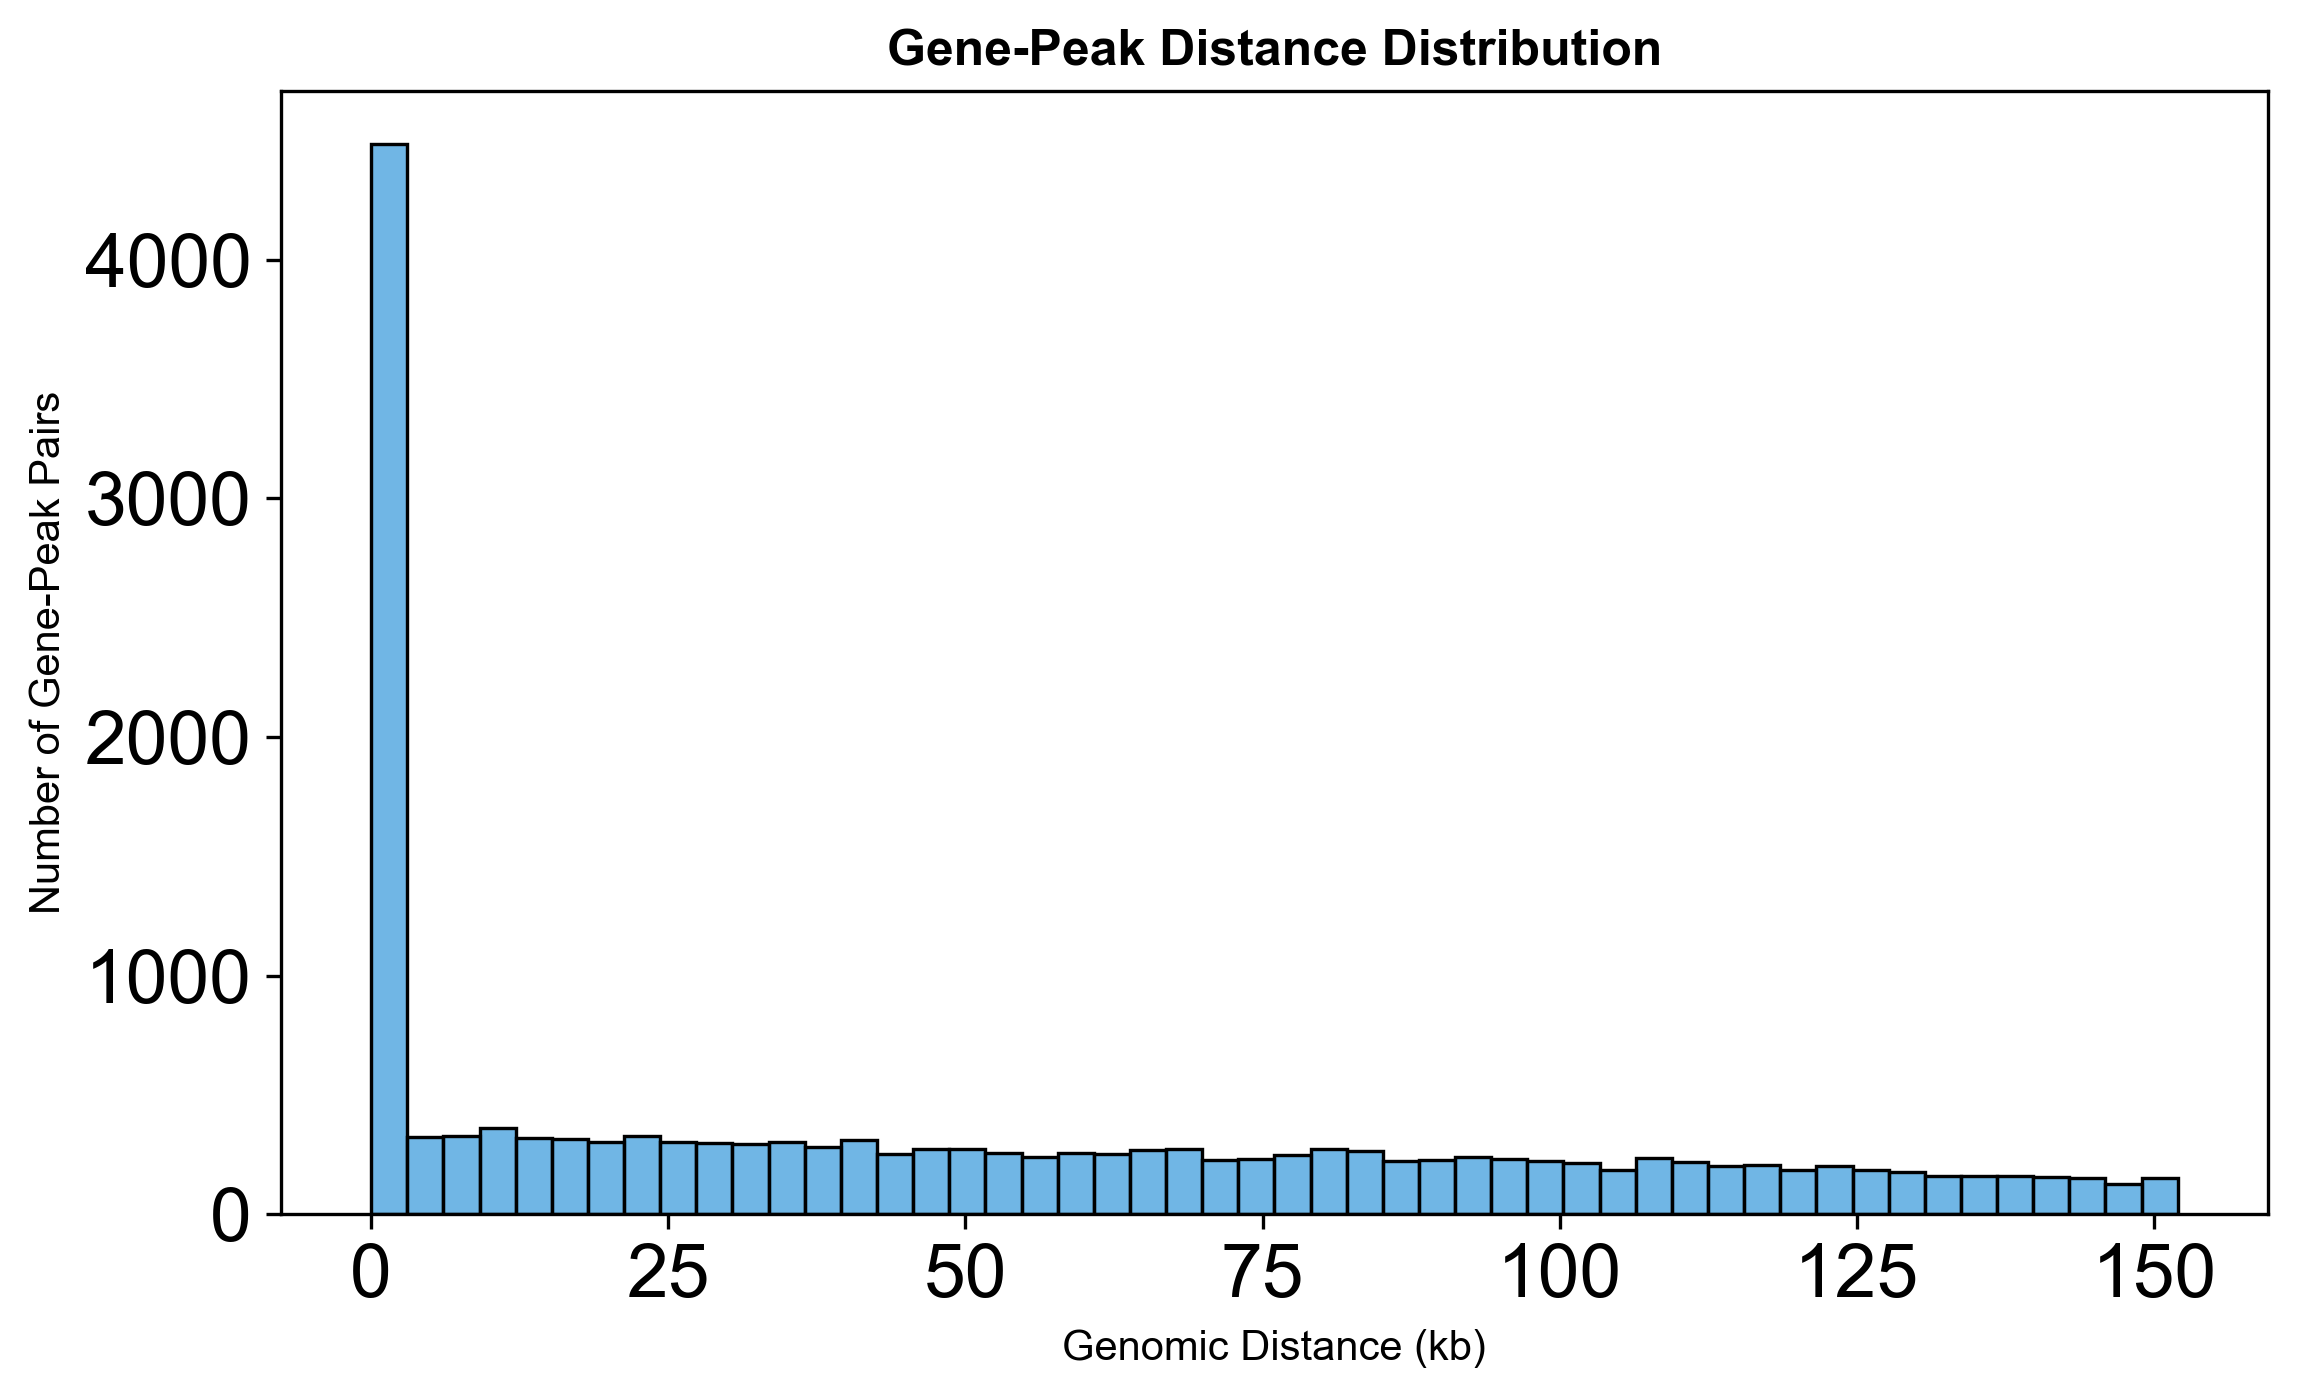

=== Genomic Distance Statistics ===
Mean distance: 49.31 kb
Median distance: 38.85 kb
Standard deviation: 46.67 kb
Total gene-peak pairs analyzed: 16,347


In [ ]:
# Generate distance distribution visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure for gene-peak distance distribution
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

# Plot histogram of genomic distances
sns.histplot(data=merged_df_filtered, x='distance', bins=50, 
            color='#3498DB', alpha=0.7, ax=ax)

# Set labels and formatting
ax.set_title('Gene-Peak Distance Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Genomic Distance (kb)', fontsize=10)
ax.set_ylabel('Number of Gene-Peak Pairs', fontsize=10)

# Save figures
plt.tight_layout()
plt.savefig('distance_comparison.pdf', bbox_inches='tight', dpi=300)
plt.savefig('distance_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

# Calculate and display distance statistics
print("=== Genomic Distance Statistics ===")
print(f"Mean distance: {merged_df_filtered['distance'].mean():.2f} kb")
print(f"Median distance: {merged_df_filtered['distance'].median():.2f} kb")
print(f"Standard deviation: {merged_df_filtered['distance'].std():.2f} kb")
print(f"Total gene-peak pairs analyzed: {len(merged_df_filtered):,}")


## 6. Results and Export {#results-export}

Summarize analysis results and export processed data:
- Filtered gene-peak attention scores with genomic annotations
- Distance calculations and statistical summaries
- Visualization files for publication

### Final Results Summary


In [ ]:
# Display final processed dataset with all key information
merged_df_filtered[['gene', 'peak', 'score', 'distance']].describe()


,score,distance
count,16347.000000,16347.000000
mean,0.142845,49.307202
std,0.279454,46.665111
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,38.848000
75%,0.155171,86.853500
max,1.000000,151.992000


In [ ]:
# Export final processed dataset
merged_df_filtered.to_csv('merged_df_filtered.csv', index=False)
print("Final dataset exported to: merged_df_filtered.csv")

Final dataset exported to: merged_df_filtered.csv


In [ ]:
# Display complete dataset with all annotations and calculated distances
merged_df_filtered

,gene,chrom,chromStart,chromEnd,peak,peak_chrom,peak_start,peak_end,score,high_attention,attention_class,distance
0,A2M,chr12,9067663,9116229,chr12-9115492-9116400,chr12,9115492,9116400,0.642624,True,High,0.000
1,A2M,chr12,9067663,9116229,chr12-9117970-9118894,chr12,9117970,9118894,0.642624,True,High,1.742
2,A2M,chr12,9067663,9116229,chr12-9064332-9065050,chr12,9064332,9065050,0.000000,False,Low,2.614
3,ABCA1,chr9,104781001,104928237,chr9-104926201-104927103,chr9,104926201,104927103,0.635348,True,High,0.000
4,ABCA1,chr9,104781001,104928237,chr9-104968056-104968871,chr9,104968056,104968871,0.000000,False,Low,39.820
...,...,...,...,...,...,...,...,...,...,...,...,...
16342,ZSWIM7,chr17,15976559,15999717,chr17-15965296-15966096,chr17,15965296,15966096,0.000000,False,Low,10.464
16343,ZSWIM7,chr17,15976559,15999717,chr17-15944636-15945512,chr17,15944636,15945512,0.000000,False,Low,31.048
16344,ZZEF1,chr17,4004444,4143020,chr17-4142763-4143403,chr17,4142763,4143403,0.648152,True,High,0.000
16345,ZZEF1,chr17,4004444,4143020,chr17-4143520-4144206,chr17,4143520,4144206,0.648152,True,High,0.501


### Analysis Summary

Gene-peak attention score analysis from MultiGATE model completed successfully.

#### Key Analysis Steps:
1. **Data preprocessing**: Loaded and filtered attention matrices
2. **Score processing**: Removed self-attention, filtered highly variable features
3. **Threshold determination**: Applied GMM to identify significant attention scores
4. **Distance calculation**: Computed genomic distances using interval-based methods
5. **Visualization**: Generated publication-quality plots and statistics

#### Final Dataset Features:
- **Gene-peak pairs**: Filtered for significant attention relationships
- **Attention scores**: Normalized (0-1) with GMM-derived threshold classification
- **Genomic distances**: Interval-based calculations in kilobases
- **Annotations**: Complete genomic coordinates for genes and peaks

#### Output Files:
- `merged_df_filtered.csv`: Final processed gene-peak attention dataset
- `merged_df_threshold.csv`: Dataset with threshold-based classifications
- `distance_comparison.pdf/png`: Distance distribution visualizations
- `Human_gaussian_mixture_density_plot.pdf`: GMM threshold analysis plot
